# Thunderstruck
## Figures 2, 3 & 6. Maps of lightning activity and cloud ice content.

In [1]:
from dataclasses import dataclass, field
from functools import partial

import cartopy.crs as ccrs
import cmocean
import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import time_mean
from aeolus.const import init_const
from aeolus.coord import roll_cube_pm180
from aeolus.core import AtmoSim
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    all_sim_file_label,
    capitalise,
    cube_minmeanmax_str,
    figsave,
    subplot_label_generator,
    tex2cf_units,
)
from matplotlib.offsetbox import AnchoredText
from tqdm import tqdm

In [2]:
from common import (
    ACCUM_PERIOD,
    GROUPS,
    KW_DELIM_LINE,
    LPC,
    M09,
    PR92,
    PROJECT,
    SIMULATIONS,
    calc_cloud_depth,
    calc_flash_rate,
    calc_total_flash_rate,
    callback_coord_system,
    extract_lfr_ratio,
)

In [3]:
SIM_GROUP = "pres"
show_groups = [SIM_GROUP]  # "comp", "surf"
show_sim = [
    sim
    for sim in SIMULATIONS.keys()
    if sim in sum([GROUPS[group_label].simulations for group_label in show_groups], ())
]
n_sim = len(show_sim)

In [4]:
dset = {}
for sim in tqdm(show_sim):
    dset[sim] = {}
    const = init_const("trap1e")  # TODO
    for scheme in LPC:
        dset[sim][scheme] = AtmoSim(
            iris.load(
                paths.data
                / "raw"
                / "steady"
                / SIMULATIONS[sim].diag_suites[LPC[scheme].suites]
                / "base"
                / LPC[scheme].model_res.lower()
                / LPC[scheme].file_mask,
                callback=partial(callback_coord_system, const=const),
            ),
            planet="trap1e",  # TODO
            model=um,
        )

100%|██████████| 6/6 [02:34<00:00, 25.73s/it]


In [5]:
# for scheme in LPC:
#     for i, cube in enumerate(dset[sim][scheme]._cubes):
#         print(f"--|-|-{'-'*20}-|-{'-'*10}-|-{'-'*65}-|-{'-'*10}")
#         print(
#             f"{i:<2d}|{cube.ndim}| {str(cube.shape):>20}"
#             f" | {str(cube.attributes['STASH']):>10}"
#             f" | {cube.name():>65} | {str(cube.units):>10}"
#         )
#     print("-" * 120)

## Maps

In [6]:
@dataclass
class Diag:
    recipe: callable
    title: str
    cbar_title: str
    units: str
    fmt: str
    kw_plt: dict = field(default_factory=dict)
    method: str = "contourf"
    rm_min: bool = False


DIAGS = {
    "lfr": Diag(
        recipe=lambda AS: calc_flash_rate(AS._cubes, accum_period=ACCUM_PERIOD),
        title="Maps of lightning activity",
        cbar_title="Flash rate",
        units="$km^{-2}$ $yr^{-1}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.thermal,
            norm=mcol.LogNorm(vmin=1e-1, vmax=1e2),
            rasterized=True,
        ),
        fmt="pretty",
        rm_min=True,
    ),
    "cld_dep": Diag(
        recipe=lambda AS: calc_cloud_depth(AS._cubes),
        title="Maps of convective cloud depth",
        cbar_title="Cloud depth",
        units="$km$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.balance_i,
            vmin=0,
            vmax=10,
            rasterized=True,
        ),
        fmt="pretty",
        rm_min=True,
    ),
    "lfr_ratio": Diag(
        recipe=lambda AS: extract_lfr_ratio(AS._cubes),
        title="Lightning Activity",
        cbar_title="LFR Ratio",
        units="1",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.delta,
            vmin=0,
            vmax=1,
            rasterized=True,
        ),
        fmt="pretty",
    ),
    "iwp": Diag(
        recipe=lambda AS: AS._cubes.extract_cube("total_ice_water_path"),
        title="Maps of ice cloud content",
        cbar_title="Total column cloud ice",
        units="$kg$ $m^{-2}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.ice_r,
            norm=mcol.LogNorm(vmin=1e-2, vmax=1e0),
            # levels=np.arange(0.1, 1.1, 0.1),
            rasterized=True,
        ),
        fmt="pretty",
        rm_min=True,
    ),
    "gwp": Diag(
        recipe=lambda AS: AS._cubes.extract_cube("graupel_water_path"),
        title="Maps of graupel",
        cbar_title="Total column graupel",
        units="$kg$ $m^{-2}$",
        method="pcolormesh",
        kw_plt=dict(
            cmap=cmocean.cm.dense,
            norm=mcol.LogNorm(vmin=1e-9, vmax=1e-2),
            # levels=np.arange(0.1, 1.1, 0.1),
            rasterized=True,
        ),
        fmt="pretty",
        rm_min=True,
    ),
    "t_sfc": Diag(
        recipe=lambda AS: AS.t_sfc,
        title="Maps of surface temperature",
        cbar_title="Surface temperature",
        units="$K$",
        method="contourf",
        kw_plt=dict(
            cmap=cmocean.cm.haline, levels=np.arange(150, 291, 20), extend="both"
        ),
        fmt="auto",
    ),
}

Saved to ../figures/thunderstruck__pres__m09__lfr__maps.pdf
Size: 51.5 KB


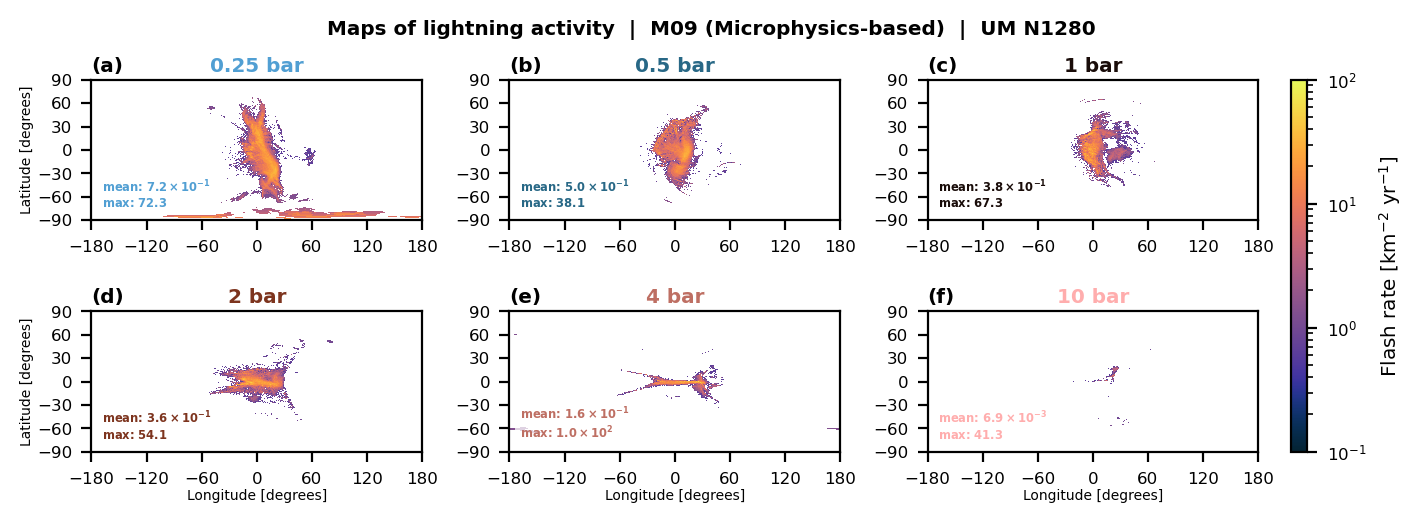

In [7]:
scheme = "m09"
diag_key = "lfr"
sep = "  |  "
# pl_type = "cart"
pl_type = ""
savefig = True

ttl = sep.join(
    [DIAGS[diag_key].title, LPC[scheme].title, f"UM {LPC[scheme].model_res}"]
)

if pl_type == "cart":
    subplot_kw = {"projection": ccrs.Robinson()}
    kw_cart = {"transform": ccrs.PlateCarree()}
else:
    subplot_kw = {}
    kw_cart = {}
    coord_mappings = {
        "longitude": dict(ticks=np.arange(-180, 181, 60), units="degrees"),
        "latitude": dict(ticks=np.arange(-90, 91, 30), units="degrees"),
    }

fig = plt.figure(figsize=(7, 2.5), layout="constrained")
fig.suptitle(ttl)
axd = fig.subplot_mosaic(
    [show_sim[: n_sim // 2] + ["cax"], show_sim[n_sim // 2 :] + ["cax"]],
    subplot_kw=subplot_kw,
    width_ratios=[1] * (len(show_sim) // 2) + [0.05],
)

iletters = subplot_label_generator()
for sim in show_sim:
    ax = axd[sim]
    ax.set_title(f"({next(iletters)})", loc="left")
    ax.set_title(
        SIMULATIONS[sim].title,
        color=SIMULATIONS[sim].kw_plt["color"],
    )
    cube = roll_cube_pm180(
        LPC[scheme].time_ave_func(DIAGS[diag_key].recipe(dset[sim][scheme]))
    )
    cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
    y, x = cube.dim_coords
    if pl_type == "cart":
        ax.gridlines(draw_labels=True)
    else:
        # ax.axvline(-90, **KW_DELIM_LINE)
        # ax.axvline(90, **KW_DELIM_LINE)
        if coord_mapping := coord_mappings.get(x.name()):
            x.convert_units(coord_mapping["units"])
            ax.set_xticks(coord_mapping["ticks"])
            ax.set_xlim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if coord_mapping := coord_mappings.get(y.name()):
            y.convert_units(coord_mapping["units"])
            ax.set_yticks(coord_mapping["ticks"])
            ax.set_ylim(coord_mapping["ticks"][0], coord_mapping["ticks"][-1])
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                f"{capitalise(y.name())} [{y.units}]", size="small", labelpad=1
            )
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(
                f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1
            )

    h = getattr(ax, DIAGS[diag_key].method)(
        x.points, y.points, cube.data, **DIAGS[diag_key].kw_plt, **kw_cart
    )
    if cont := SIMULATIONS[sim].continent:
        cont.add_to_ax(ax, fc="none", ec="k", linewidth=0.1, hatch="////", **kw_cart)
    if iris.util.guess_coord_axis(x) == "X" and iris.util.guess_coord_axis(y) == "Y":
        stats_str = cube_minmeanmax_str(
            cube,
            fmt=DIAGS[diag_key].fmt,
            precision=1,
            sep="\n",
            eq_sign=": ",
        )
        if DIAGS[diag_key].rm_min:
            stats_str = "\n".join(stats_str.split("\n")[1:])
        at = AnchoredText(
            stats_str,
            loc="lower left",
            frameon=True,
            prop={
                "size": "x-small",
                "weight": "bold",
                "color": SIMULATIONS[sim].kw_plt["color"],
            },
        )
        at.patch.set_facecolor(mcol.to_rgba("w", alpha=0.75))
        at.patch.set_edgecolor("none")
        ax.add_artist(at)
cbar = fig.colorbar(h, cax=axd["cax"])
cbar.ax.set_ylabel(
    f"{DIAGS[diag_key].cbar_title} [{DIAGS[diag_key].units}]", fontsize="large"
)
if savefig:
    figsave(
        fig,
        paths.figures
        / (
            f"{PROJECT}__{SIM_GROUP}__{scheme}__{diag_key}"
            f"__maps{'__'+pl_type if pl_type else ''}"
        ),
    )